# Example 

Reference: https://www.kaggle.com/code/johnmckinstry/utkface-age-prediction-gtech-final-project

In [1]:
import os
import time
import pandas as pd
import numpy as np
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid

from tqdm import tqdm_notebook as tqdm
from PIL import Image

import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset

import torchvision
import torchvision.transforms as transforms



In [2]:
DATA_PATH = r"D:\dataset\utkcropped\utkcropped"
SAVE_PATH = "."

def reload_data():
    age_list = []
    gender_list = []
    race_list = []
    datetime_list = []
    filename_list = []

    for filename in os.listdir(DATA_PATH):

        args = filename.split("_")

        if len(args)<4:
            age = int(args[0])
            gender = int(args[1])
            race = 4
            datetime = args[2].split(".")[0]
        else:
            age = int(args[0])
            gender = int(args[1])
            race = int(args[2])
            datetime = args[3].split(".")[0]

        age_list.append(age)
        gender_list.append(gender)
        race_list.append(race)
        datetime_list.append(datetime)
        filename_list.append(filename)


    d = {'age': age_list, 'gender': gender_list, 'race': race_list, 'datetime': datetime_list, 'filename': filename_list}
    return pd.DataFrame(data=d)
    
df = reload_data()

In [3]:
df["race"] = df["race"].replace( {0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Others"})
df["gender"] = df["gender"].replace(regex={0: "male", 1: "female"})

In [4]:
df.head()

,age,gender,race,datetime,filename
0,100,male,White,20170112213500903,100_0_0_20170112213500903.jpg.chip.jpg
1,100,male,White,20170112215240346,100_0_0_20170112215240346.jpg.chip.jpg
2,100,female,White,20170110183726390,100_1_0_20170110183726390.jpg.chip.jpg
3,100,female,White,20170112213001988,100_1_0_20170112213001988.jpg.chip.jpg
4,100,female,White,20170112213303693,100_1_0_20170112213303693.jpg.chip.jpg


Choose one Age in: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 99, 100, 101, 103, 105, 110, 111, 115, 116]

Choose one Gender in: ['male' 'female' 3]

Choose one Race (or "all") in: ['White' 'Asian' 'Black' 'Indian' 'Others']



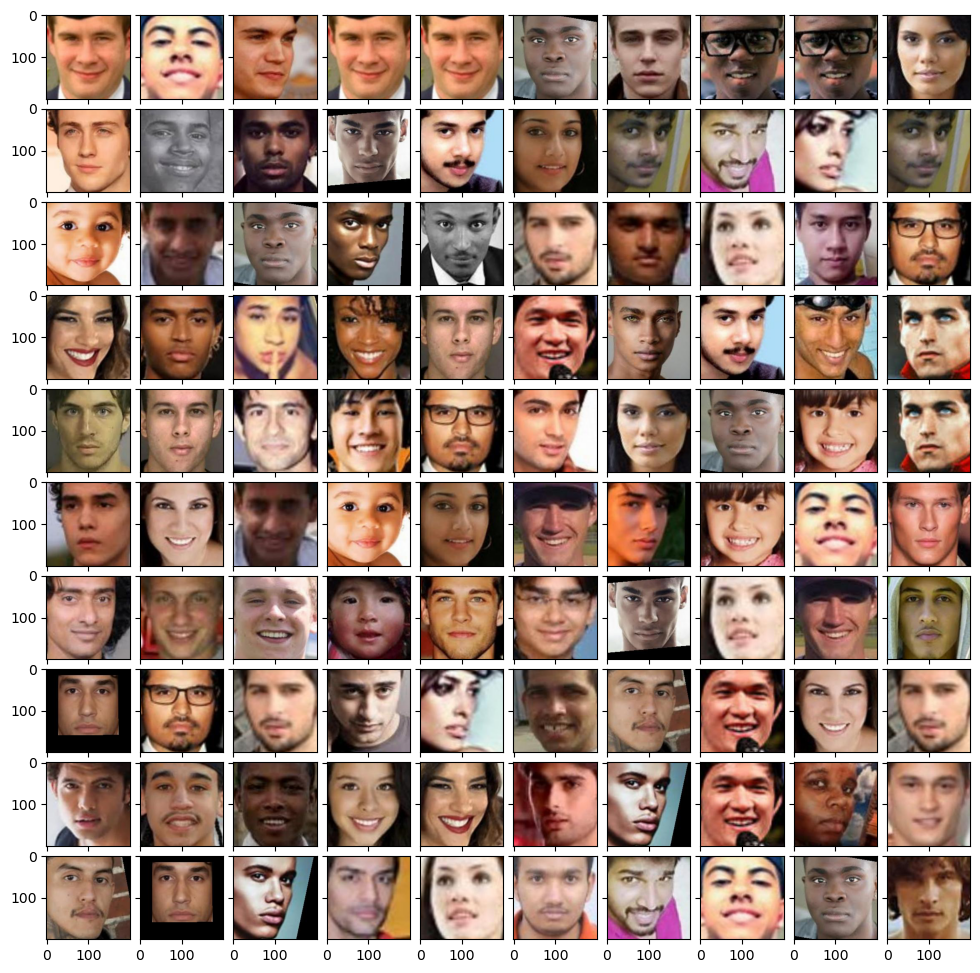

In [5]:
# Options
print(f'Choose one Age in: {sorted(df["age"].unique())}\n')
print(f'Choose one Gender in: {df["gender"].unique()}\n')
print(f'Choose one Race (or "all") in: {df["race"].unique()}\n')

# Define Specifics
age = 21
gender = 'male'
race = 'all'

if race == 'all':
    image = df.loc[(df["gender"] == gender) & (df["age"] == age)]
else:
    image = df.loc[(df["gender"] == gender) & (df["race"] == race) & (df["age"] == age)]
    
fig = plt.figure(figsize=(12., 12.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(10, 10),
                 axes_pad=0.1,  
                 )

for ax in grid:
    ax.imshow(Image.open(os.path.join(DATA_PATH, 
                                      image["filename"].iloc[np.random.randint(len(image))]) ))

plt.show()

In [6]:
print("maximum age:",df["age"].max())
print("minimum age:",df["age"].min())
print("mean age:","%.2f" % df["age"].mean())
print("standard deviation age:","%.2f" % df["age"].std())

maximum age: 116
minimum age: 1
mean age: 33.31
standard deviation age: 19.88


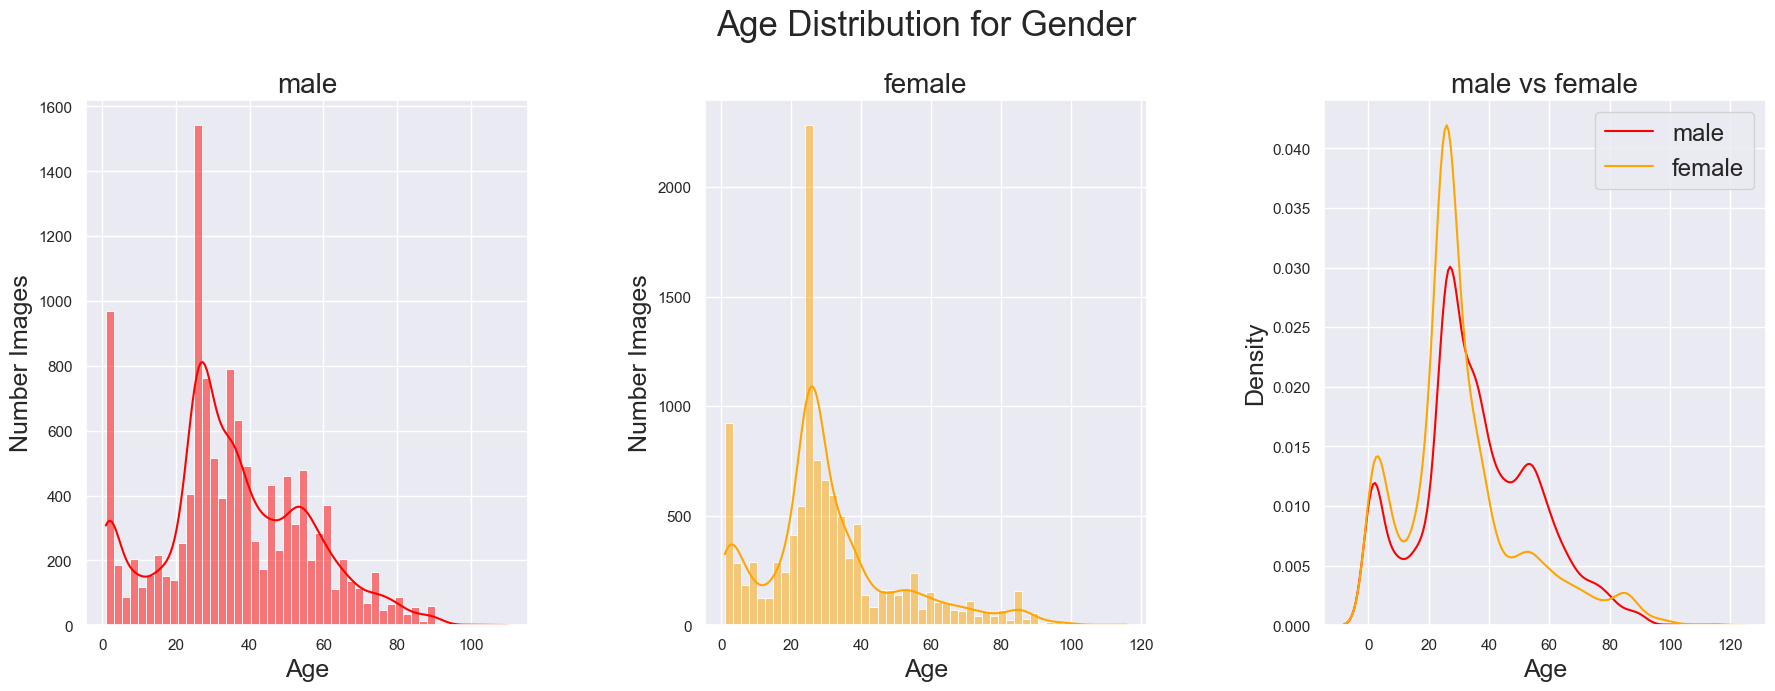

In [7]:
sns.set_theme()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 7))
fig.suptitle('Age Distribution for Gender', fontsize=25)
sns.set(font_scale = 1.2)

df_age_male = df.groupby('gender').get_group("male")
df_age_female = df.groupby('gender').get_group("female")
h = sns.histplot(data=df_age_male, x="age", kde=True, color="red", ax=ax1, bins=50)
h.set_xlabel("Age", fontsize=18)
h.set_ylabel("Number Images", fontsize=18)
h = sns.histplot(data=df_age_female, x="age", kde=True, color="orange", ax=ax2, bins=50)
h.set_xlabel("Age", fontsize=18)
h.set_ylabel("Number Images", fontsize=18)
ax1.set_title("male", fontdict = {'fontsize': 20})
ax2.set_title("female", fontdict = {'fontsize': 20})

sns.kdeplot(data=df_age_male, x="age", color="red", ax=ax3)
h = sns.kdeplot(data=df_age_female, x="age", color="orange", ax=ax3)
ax3.legend(["male", "female"], fontsize="large")
ax3.set_title("male vs female", fontdict = {'fontsize': 20})
h.set_xlabel("Age", fontsize=18)
h.set_ylabel("Density", fontsize=18)


plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.85, wspace=0.4, hspace=0.4)
# plt.savefig(SAVE_PATH + "utkface_age_gender_distribution.png", bbox_inches='tight')
# plt.show()

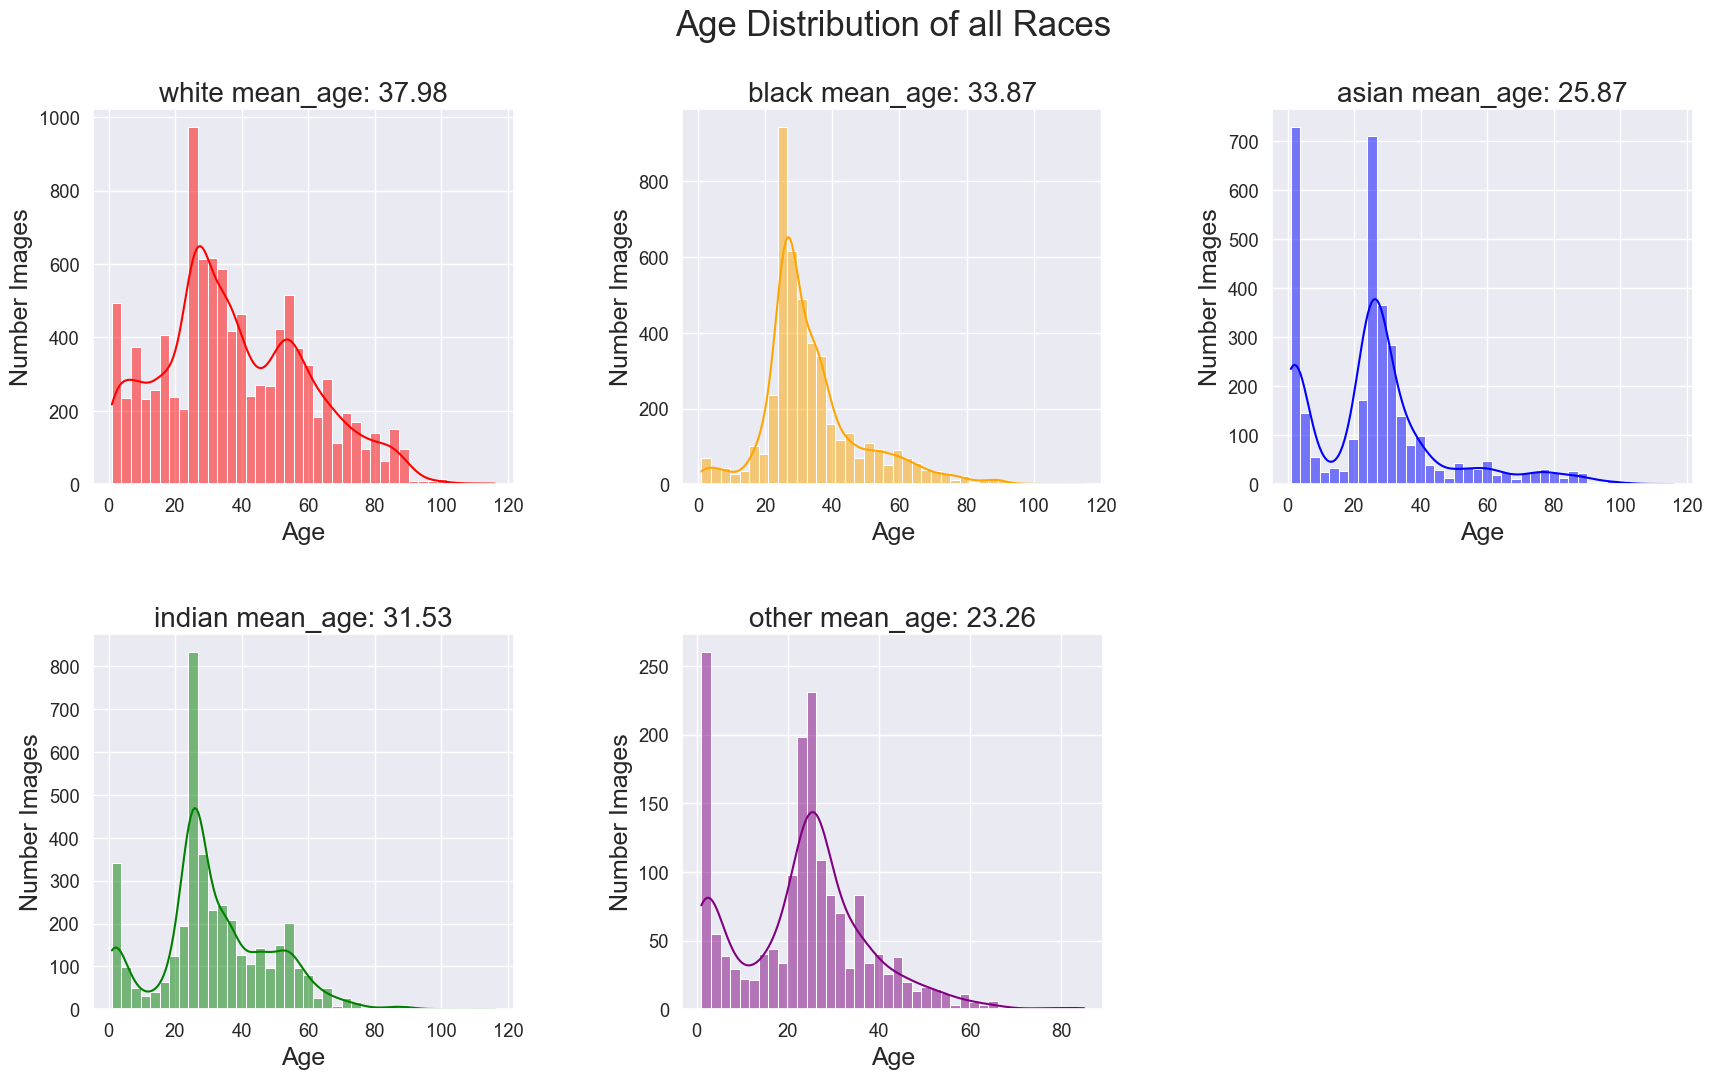

In [8]:
fig = plt.figure(figsize=(20,10))
fig.suptitle('Age Distribution of all Races', fontsize=25, y=1.1)
fig.tight_layout()
sns.set(font_scale = 1.2)


plt.subplot(2, 3, 1)
df_race_white = df.groupby('race').get_group("White")
h = sns.histplot(data=df_race_white, x="age", kde=True, color="red", bins=40)
h.set_xlabel("Age", fontsize=18)
h.set_ylabel("Number Images", fontsize=18)
plt.title("white mean_age: "+"%.2f" % df_race_white['age'].mean(), fontsize=20)

plt.subplot(2, 3, 2)
df_race_black = df.groupby('race').get_group("Black")
h = sns.histplot(data=df_race_black, x="age", kde=True, color="orange", bins=40)
h.set_xlabel("Age", fontsize=18)
h.set_ylabel("Number Images", fontsize=18)
plt.title("black mean_age: "+"%.2f" % df_race_black['age'].mean(), fontsize=20)

plt.subplot(2, 3, 3)
df_race_asian = df.groupby('race').get_group("Asian")
h = sns.histplot(data=df_race_asian, x="age", kde=True, color="blue", bins=40)
h.set_xlabel("Age", fontsize=18)
h.set_ylabel("Number Images", fontsize=18)
plt.title("asian mean_age: "+"%.2f" % df_race_asian['age'].mean(), fontsize=20)

plt.subplot(2, 3, 4)
df_race_indian = df.groupby('race').get_group("Indian")
h = sns.histplot(data=df_race_indian, x="age", kde=True, color="green", bins=40)
h.set_xlabel("Age", fontsize=18)
h.set_ylabel("Number Images", fontsize=18)
plt.title("indian mean_age: "+"%.2f" % df_race_indian['age'].mean(), fontsize=20)

plt.subplot(2, 3, 5)
df_race_other = df.groupby('race').get_group("Others")
h = sns.histplot(data=df_race_other, x="age", kde=True, color="purple", bins=40)
h.set_xlabel("Age", fontsize=18)
h.set_ylabel("Number Images", fontsize=18)
plt.title("other mean_age: "+"%.2f" % df_race_other['age'].mean(), fontsize=20)




plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=1, wspace=0.4, hspace=0.4)
# plt.savefig(SAVE_PATH + "utkface_age_race_distribution.png", bbox_inches='tight')
# plt.show()

In [9]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

import math

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ColorJitter

import torch.optim as optim

DATA_PATH = r"D:\dataset\utkcropped\utkcropped"

#################################
###     Conv. NN
#################################
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        # 3 input image channel, 6 output channels, 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=1)
	      # Max pooling over a (2, 2) window
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2_out_tup = (16,25,25)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=self.conv2_out_tup[0], kernel_size=5, stride=2, padding=2) 
        self.fc1 = nn.Linear(16 * 25 * 25, 120)# 25*25 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        # print(x.size())
        # torch.Size([64, 6, 100, 100])
        
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.size())
        # torch.Size([64, 16, 25, 25])
        
        x = x.view(-1,self.conv2_out_tup[0]*self.conv2_out_tup[1]*self.conv2_out_tup[2])
        # print(x.size())
        # torch.Size([64, 10000])
        
        x = F.relu(self.fc1(x))
        # print(x.size())
        # torch.Size([64, 120])
        
        x = F.relu(self.fc2(x))
        # print(x.size())
        # torch.Size([64, 84])
        
        x = self.fc3(x)
        # print(x.size())
        # torch.Size([64, 10])
        
        return x

#################################
###     Modified CNN
#################################
class Modified_CNN(nn.Module):
    def __init__(self):
        super(Modified_CNN, self).__init__()

        # 3 input image channel, 6 output channels, 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
	      # Max pooling over a (2, 2) window
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv1_out_tup = (64,100,100)
        
        self.conv2_out_tup = (128,50,50)
        self.conv2 = nn.Conv2d(in_channels=self.conv1_out_tup[0], out_channels=self.conv2_out_tup[0], kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.conv3_out_tup = (256,25,25)
        self.conv3 = nn.Conv2d(in_channels=self.conv2_out_tup[0], out_channels=self.conv3_out_tup[0], kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.conv4_out_tup = (512,13,13)
        self.conv4 = nn.Conv2d(in_channels=self.conv3_out_tup[0], out_channels=self.conv4_out_tup[0], kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.conv5_out_tup = (1024,7,7)
        self.conv5 = nn.Conv2d(in_channels=self.conv4_out_tup[0], out_channels=self.conv5_out_tup[0], kernel_size=3, stride=1, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        
        self.fc1 = nn.Linear(1024 * 7 * 7, 120)# 25*25 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.fc4 = nn.Linear(10, 1)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x))) 
        x = self.pool4(F.relu(self.conv4(x))) 
        x = self.pool5(F.relu(self.conv5(x)))
        x = x.view(-1,self.conv5_out_tup[0]*self.conv5_out_tup[1]*self.conv5_out_tup[2])
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x)) 
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x

#################################
###     DLDLv2
#################################
def Conv(in_channels, out_channels, kerner_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kerner_size, stride, padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(True),
    )


class TinyAge(nn.Module):  # Compression rate of 0.25
    def __init__(self):
        super(TinyAge, self).__init__()
        
        # First Block
        self.c1 = Conv(3, 16, 3, 1, 1)
        self.c2 = Conv(16, 16, 3, 1, 1)
        self.p1 = nn.MaxPool2d(2, 2)
        
        # Second Block
        self.c3 = Conv(16, 32, 3, 1, 1)
        self.c4 = Conv(32, 32, 3, 1, 1)
        self.p2 = nn.MaxPool2d(2, 2)
        
        # Third Block
        self.c5 = Conv(32, 64, 3, 1, 1)
        self.c6 = Conv(64, 64, 3, 1, 1)
        self.p3 = nn.MaxPool2d(2, 2)
        
        # Forth Block
        self.c7 = Conv(64, 128, 3, 1, 1)
        self.c8 = Conv(128, 128, 3, 1, 1)
        self.c9 = Conv(128, 128, 3, 1, 1)
        self.p5 = nn.MaxPool2d(2, 2)
        
        # Final Push
        self.c10 = Conv(128, 128, 3, 1, 1)
        self.c11 = Conv(128, 128, 3, 1, 1)
        self.c12 = Conv(128, 128, 3, 1, 1)
        
        self.HP = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.AvgPool2d(kernel_size=7, stride=1)
        )
        
        self.l1 = nn.Sequential(
            nn.Linear(128, 101),
            nn.Sigmoid()
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.p1(self.c2(self.c1(x)))
        x = self.p2(self.c4(self.c3(x)))
        x = self.p3(self.c6(self.c5(x)))
        x = self.p5(self.c9(self.c8(self.c7(x))))
        
        x = self.HP(self.c12(self.c11(self.c10(x))))
        x = x.view((x.size(0), -1))
        x = self.l1(x.view((x.size(0), -1)))
        x = F.normalize(x, p=1, dim=1)
        
        return x

class ThinAge(nn.Module):  # Compression rate of 0.5
    def __init__(self):
        super(ThinAge, self).__init__()
        
        # First Block
        self.c1 = Conv(3, 32, 3, 1, 1)
        self.c2 = Conv(32, 32, 3, 1, 1)
        self.p1 = nn.MaxPool2d(2, 2)
        
        # Second Block
        self.c3 = Conv(32, 64, 3, 1, 1)
        self.c4 = Conv(64, 64, 3, 1, 1)
        self.p2 = nn.MaxPool2d(2, 2)
        
        # Third Block
        self.c5 = Conv(64, 128, 3, 1, 1)
        self.c6 = Conv(128, 128, 3, 1, 1)
        self.c7 = Conv(128, 128, 3, 1, 1)
        self.p3 = nn.MaxPool2d(2, 2)
        
        # Fourth Block
        self.c8 = Conv(128, 256, 3, 1, 1)
        self.c9 = Conv(256, 256, 3, 1, 1)
        self.c10 = Conv(256, 256, 3, 1, 1)
        self.p4 = nn.MaxPool2d(2, 2)
        
        # Final Push
        self.c11 = Conv(256, 256, 3, 1, 1)
        self.c12 = Conv(256, 256, 3, 1, 1)
        self.c13 = Conv(256, 256, 3, 1, 1)
        
        self.HP = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.AvgPool2d(kernel_size=7, stride=1)
        )
        self.l1 = nn.Sequential(
            nn.Linear(256, 101),
            nn.Sigmoid()
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.p1(self.c2(self.c1(x)))
        x = self.p2(self.c4(self.c3(x)))
        x = self.p3(self.c7(self.c6(self.c5(x))))
        x = self.p4(self.c10(self.c9(self.c8(x))))
        
        x = self.HP(self.c13(self.c12(self.c11(x))))
        x = x.view((x.size(0), -1))
        x = self.l1(x.view((x.size(0), -1)))
        x = F.normalize(x, p=1, dim=1)
        
        return x
    
#################################
###     CORAL
#################################
##########################
# Coral Model: Consistent Cumulative Logits with ResNet-34
##########################

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.num_classes = num_classes
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(4)
        self.fc = nn.Linear(512, 1, bias=False)
        #self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        #self.fc = nn.Linear(2048 * block.expansion, 1, bias=False)
        self.linear_1_bias = nn.Parameter(torch.zeros(self.num_classes-1).float())

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        logits = logits + self.linear_1_bias
        probas = torch.sigmoid(logits)
        
        if self.training:
            outVal = logits
        else:
            #predict_levels = probas > 0.5
            #predict_levels = (probas > 0.5).float()
            thresh = nn.Threshold(0.5, 0.0)
            thresh2 = nn.Threshold(-0.5, -1.0)
            predict_levels = -thresh2(-thresh(probas))
            #print(probas)
            #print(predict_levels)
            outVal = torch.sum(predict_levels, dim=1)
            #predicted_labels = torch.sum(predict_levels, dim=1)
            #outVal = torch.as_tensor(predicted_labels, dtype=float)
        
        #return logits, probas
        return outVal
    
'''

    MODEL UTILITY FUNCTIONS

'''
def run_model(n_classes, model_type='Basic_CNN'):
    if model_type == 'Basic_CNN':
        bs = 128
        lr = 0.001159826
        wd = 5.02696e-05
        epoch_ct = 5
        
        return Network(), bs, lr, wd, epoch_ct
    elif model_type == 'DLDLv2-Thin':
        bs = 64
        lr = 0.005
        wd = 0.0001
        epoch_ct = 10
        
        return ThinAge(), bs, lr, wd, epoch_ct
    elif model_type == 'DLDLv2-Tiny':
        bs = 64
        lr = 0.001
        wd = 0.0005
        epoch_ct = 25
        
        return TinyAge(), bs, lr, wd, epoch_ct
    elif model_type == 'ViT':
        bs = 128
        lr = 0.001
        wd = 0.0001
        epoch_ct = 10
        
        return ViT(rearrage_func=rearrange), bs, lr, wd, epoch_ct
    elif model_type == 'Modified_CNN':
        bs = 32  # 64
        lr = 0.0006702045960679336
        wd = 0.00010139404641850778
        epoch_ct = 25
        
        return Modified_CNN(), bs, lr, wd, epoch_ct
    elif model_type == 'Coral':
        gray_scale = False
        
        bs = 256
        lr = 5.0e-04
        wd= 1.0e-7
        epoch_ct = 250
        
        return resnet34(n_classes, gray_scale), bs, lr, wd, epoch_ct

    
def saveModel(model_type='Basic_CNN', trans=None):
    if trans:
        path = f'{SAVE_PATH}{model_type}-aug.pth'
    else:
        path = f'{SAVE_PATH}{model_type}.pth'
    torch.save(model.state_dict(), path)
    
    
def loadModel(n_classes, model_type='Basic_CNN'):
    model_ = run_model(n_classes, model_type)[0]
    model_.load_state_dict(torch.load(f'{SAVE_PATH}{model_type}.pth'))
    return model_.eval()


class CustomImageDataset(Dataset):
    def __init__(self, df_, img_transform=None, target_transform=None):
        if img_transform:
            self.transform = transforms.Compose([transforms.ToTensor(),
                                                 img_transform])
        else:
            self.transform = transforms.Compose([transforms.ToTensor()])
        self.target_transform = target_transform
        self.df_ = df_

    def __len__(self):
        return len(self.df_['age'])

    def __getitem__(self, idx):
#         image = Image.open("/kaggle/input/utkface-new/crop_part1" + self.df_['filename'].iloc[idx])
        image = Image.open(os.path.join(DATA_PATH, self.df_['filename'].iloc[idx]))
        label = self.df_['age'].iloc[idx]

        image = self.transform(image)

        if self.target_transform:
            label = self.target_transform(label)

        return image, label

class CoralDataset(Dataset):
    """Custom Dataset for loading CORAL face images"""

    def __init__(self, df_, num_classes, img_transform=None):
        if img_transform:
            self.transform = img_transform
        else:
            self.transform = transforms.Compose([transforms.ToTensor()])

        self.df_ = df_
        self.num_classes = num_classes

    def __getitem__(self, idx):
        image = Image.open(DATA_PATH + self.df_['filename'].iloc[idx])
        label = self.df_['age'].iloc[idx]

        if self.transform is not None:
            image = self.transform(image)

        levels = [1]*label + [0]*(self.num_classes - 1 - label)
        levels = torch.tensor(levels, dtype=torch.float32)

        return image, label, levels

    def __len__(self):
        return len(self.df_['age'])

def train(model, train_, test_, num_epochs, trans=None):
    
    best_mae = np.inf
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    num_trans = len(trans) if trans else 1
     
    if trans:
        t_ = CustomImageDataset(train_)
        
        for t in trans:
            ds_ = CustomImageDataset(train_, img_transform=t)
            t_ = ConcatDataset([t_, ds_])
            
        train_loader = DataLoader(t_, batch_size=batch_size, shuffle=True)
    else:
        train_loader = DataLoader(CustomImageDataset(train_), batch_size=batch_size, shuffle=True)
    
    print(f'Num Transforms: {num_trans}')
    
    epochs = np.arange(1, num_epochs + 1)
    losses_trn = np.arange(1.0*num_epochs)
    losses_val = np.arange(1.0*num_epochs)

    for epoch in range(num_epochs):
        running_loss, run_count = 0.0, 0
        for i, (images, labels) in enumerate(train_loader):
            images = Variable(images)
            images = images.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            labels = labels.float().unsqueeze(1)
            labels = labels.to(device)

            loss = loss_fn(outputs, labels.float())   
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            run_count += 1

            if i % 1000 == 999:    
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 1000))
                running_loss = 0.0

            if i % 100 == 99 and False: # Change false to true if you want to see actual outputs for a training iteration
                print("output :")
                print(outputs)
                print("labels :")
                print(labels)
                
        mae = testMeanAbsoluteError(test_)
        print(f"For epoch', {epoch + 1},'train MAE {running_loss / run_count} | test MAE: {mae}")
        
    saveModel(model_type, trans)  # saving last model version since the MAE results are based on 10 full epochs


def training_coral(model, train_, test_, num_epochs, trans=None):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    if not importance_weight:
        imp = torch.ones(num_classes - 1, dtype=torch.float)
    else:
        imp = task_importance_weights(train_df['age'].values, num_classes)
        imp = imp[0:num_classes - 1]
    
    model.to(device)
    imp = imp.to(device)

    if trans is None:
        custom_transform = transforms.Compose([transforms.Resize((128, 128)),
                                               transforms.RandomCrop((120, 120)),
                                               transforms.ToTensor()])
    else:
        tranList = [transforms.Resize((128, 128))] + trans + [transforms.CenterCrop((120, 120)), transforms.ToTensor()]
        custom_transform = transforms.Compose(tranList)

    custom_transform2 = transforms.Compose([transforms.Resize((128, 128)),
                                            transforms.CenterCrop((120, 120)),
                                            transforms.ToTensor()])

    #custom_transform = transforms.Compose([transforms.ToTensor()])
    #custom_transform2 = transforms.Compose([transforms.ToTensor()])

    train_ds = CoralDataset(train_, num_classes, custom_transform)
    validation_ds = CoralDataset(test_, num_classes, custom_transform2)

    train_loader = DataLoader(dataset=train_ds, batch_size=batch_size)
    validation_loader = DataLoader(dataset=validation_ds, batch_size=batch_size)

    start_time = time.time()
    train_mae_list = []
    valid_mae_list = []

    best_mae, best_rmse, best_epoch = np.inf, np.inf, -1
    for epoch in range(num_epochs):

        model.train()

        for batch_idx, (features, targets, levels) in enumerate(train_loader):
            
            features = features.to(device)
            targets = targets
            targets = targets.to(device)
            levels = levels.to(device)

            # FORWARD AND BACK PROP
            logits = model(features)
            cost = cost_fn(logits, levels, imp)
            optimizer.zero_grad()

            cost.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            if not batch_idx % 50:
                s = ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                     % (epoch + 1, num_epochs, batch_idx,
                        len(train_ds) // batch_size, cost))
                print(s)

        model.eval()
        with torch.set_grad_enabled(False):
            train_mae, train_mse = compute_mae_and_mse(model, train_loader,
                                                   device=device)
            
            valid_mae, valid_mse = compute_mae_and_mse(model, validation_loader,
                                                       device=device)

        if valid_mae < best_mae:
            best_mae, best_rmse, best_epoch = valid_mae, torch.sqrt(valid_mse), epoch
            ########## SAVE MODEL #############
            path = f'{SAVE_PATH}{model_type}.pth'
            torch.save(model.state_dict(), path)

        s = 'MAE/RMSE: | Current Train: %.2f/%.2f | Current Valid: %.2f/%.2f Ep. %d | Best Valid : %.2f/%.2f Ep. %d' % (
              train_mae, torch.sqrt(train_mse), valid_mae, torch.sqrt(valid_mse), epoch, best_mae, best_rmse, best_epoch)
        print(s)
        
        train_mae_list.append(train_mae.item())
        valid_mae_list.append(valid_mae.item())

        s = 'Time elapsed: %.2f min' % ((time.time() - start_time) / 60)
        print(s)

    model.eval()
    with torch.set_grad_enabled(False):  # save memory during inference

        train_mae, train_mse = compute_mae_and_mse(model, train_loader,
                                                   device=device)
        valid_mae, valid_mse = compute_mae_and_mse(model, validation_loader,
                                                   device=device)

        s = 'MAE/RMSE: | Train: %.2f/%.2f | Valid: %.2f/%.2f' % (
            train_mae, torch.sqrt(train_mse),
            valid_mae, torch.sqrt(valid_mse))
        print(s)

    s = 'Total Training Time: %.2f min' % ((time.time() - start_time) / 60)
    print(s)
    
    # For data collection purposes
    print('Train MAE')
    print(train_mae_list)
    print('Validation MAE')
    print(valid_mae_list)
    
    plotCurves(train_mae_list, valid_mae_list, 'Coral MAE Loss', 'CoralLearningCurves')

def plotCurves(trainLoss, valLoss, title, path):
    x_val = range(len(trainLoss))

    plt.plot(x_val, trainLoss, color='blue', label='Training')
    plt.plot(x_val, valLoss, color='orange', label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('MAE Loss')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.savefig(f'{SAVE_PATH}{path}.png')
    plt.show()
    
    
def testMeanAbsoluteError(test_):
    # get device to move tensor to
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    running_mae = 0.0
    
    test_loader = CustomImageDataset(test_)

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            
            # because we are running this in a for loop, we need to add a batch of 1 to the image tensor.
            if len(images.size()) == 3:
                images = images.unsqueeze(0)

            outputs = model(images)
            predicted = torch.max(outputs.data)
            #move predicted to cpu for comparison
            predicted = predicted.cpu()
            
            running_mae += np.abs(predicted-labels)

    mae = running_mae / len(test_loader)
    return(mae)

In [10]:
#model = Network()

# https://arxiv.org/abs/2105.06746
model = Modified_CNN()

#https://www.ijcai.org/proceedings/2018/0099.pdf
#https://github.com/wwwht/DLDL-v2-PyTorch
# DLDL-v2 (Tiny)
#model = TinyAge()
# DLDL-v2 (Thin)
#model = ThinAge()

In [11]:
# https://arxiv.org/abs/2010.11929 #ViT
# ViT 
from einops import rearrange

class Block(nn.Module):

    def __init__(self, 
                 dim_linear, 
                 heads=4, 
                 dim_head=None,
                 dim_linear_hidden=1024, 
                 dropout=0):

        super().__init__()

        self.mha = nn.MultiheadAttention(dim_linear, heads, dropout, bias=False)
        
        self.drop1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(dim_linear)
        self.norm2 = nn.LayerNorm(dim_linear)

        self.linear1 = nn.Sequential(
            nn.Linear(dim_linear, dim_linear_hidden),
            nn.GELU, # nn.ReLU
            nn.Dropout(dropout),
            nn.Linear(dim_linear_hidden, dim_linear),
            nn.Dropout(dropout)
        )

    def forward(self, img):
        mh = self.mha(img)
        enc = self.norm1(self.drop1(mh) + img)
        y = self.norm2(self.linear1(enc) + enc)
        return y


class ViT(nn.Module):
    def __init__(self, *, 
                 img_dim = 200,
                 patch_dim = 50,
                 dim_linear=1024,
                 blocks=12,
                 heads=4,
                 dim_linear_hidden=1024,
                 dropout=0):

        super().__init__()

        self.patch_dim = patch_dim
        inp_channels = 3
        self.token_dim = inp_channels * (patch_dim ** 2)
        self.dim_head = int(dim_linear / heads)
        self.linear1 = nn.Linear(self.token_dim, dim_linear)
        self.drop1 = nn.Dropout(dropout)

        num_tokens = (img_dim / patch_dim) ** 2
        self.embeddings = nn.Parameter(torch.randn(num_tokens, dim_linear))

        self.blocks = []
        for i in range(blocks):
            b_i = Block(dim_linear, heads, dim_head, dim_linear_block, dropout)
            self.blocks.append(b_i)
            
        self.layers = nn.ModuleList(self.blocks)
        
    def forward(self, img):
                
        image_patches = rearrange(img, 'b c (px x) (py y) -> b (x y) (px py c)', px=self.patch_dim, py=self.patch_dim)
            
        projected_patches = self.linear1(image_patches)
        patch_embeddings = self.drop1(projected_patches + self.embeddings)
        
        for layer in self.layers:
            x = layer(patch_embeddings)
            patch_embeddings = x
            
        return patch_embeddings

In [12]:
# Paper Reference: https://arxiv.org/abs/1901.07884
# Code Reference: https://github.com/Raschka-research-group/coral-cnn

torch.backends.cudnn.deterministic = True

def resnet34(num_classes, grayscale):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock,
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes,
                   grayscale=grayscale)
    return model


###################
# Utility
###################

def cost_fn(logits, levels, imp):
    val = (-torch.sum((F.logsigmoid(logits)*levels
                      + (F.logsigmoid(logits) - logits)*(1-levels))*imp,
           dim=1))
    return torch.mean(val)

def task_importance_weights(label_array, num_classes):
    label_array = torch.tensor(label_array, dtype=torch.float)
    uniq = torch.unique(label_array)
    #print(uniq)
    num_examples = label_array.size(0)

    m = torch.zeros(num_classes)

    for i, t in enumerate(torch.arange(0, num_classes)):
        m_k = torch.max(torch.tensor([label_array[label_array > t].size(0),
                                      num_examples - label_array[label_array > t].size(0)]))
        m[i] = torch.sqrt(m_k.float())

    imp = m/torch.max(m)
    return imp


def compute_mae_and_mse(model, data_loader, device):
    mae, mse, num_examples = 0, 0, 0
    for i, (features, targets, levels) in enumerate(data_loader):

        features = features.to(device)
        targets = targets.to(device)

        #logits, probas = model(features)
        #predict_levels = probas > 0.5
        #predicted_labels = torch.sum(predict_levels, dim=1)
        
        predicted_labels = model(features)
        
        num_examples += targets.size(0)
        mae += torch.sum(torch.abs(predicted_labels - targets))
        mse += torch.sum((predicted_labels - targets)**2)
    mae = mae.float() / num_examples
    mse = mse.float() / num_examples
    return mae, mse

## Training

### Select Model

In [13]:
split_size = .8
shuffle_dataset = True
random_seed = 42

num_classes = df["age"].max() + 1
importance_weight = True

def run_model(model_type='Basic_CNN'):
    if model_type == 'Basic_CNN':
        bs = 128
        lr = 0.001159826
        wd = 5.02696e-05
        epoch_ct = 5
        
        return Network(), bs, lr, wd, epoch_ct
    elif model_type == 'DLDLv2-Thin':
        bs = 64
        lr = 0.005
        wd = 0.0001
        epoch_ct = 10
        
        return ThinAge(), bs, lr, wd, epoch_ct
    elif model_type == 'DLDLv2-Tiny':
        bs = 64
        lr = 0.001
        wd = 0.0005
        epoch_ct = 25
        
        return TinyAge(), bs, lr, wd, epoch_ct
    elif model_type == 'ViT':
        bs = 128
        lr = 0.001
        wd = 0.0001
        epoch_ct = 10
        
        return ViT(rearrage_func=rearrange), bs, lr, wd, epoch_ct
    elif model_type == 'Modified_CNN':
        bs = 32  # 64
        lr = 0.0006702045960679336
        wd = 0.00010139404641850778
        epoch_ct = 25
        
        return Modified_CNN(), bs, lr, wd, epoch_ct
    elif model_type == 'Coral':
        gray_scale = False
        
        bs = 256
        lr = 5.0e-04
        wd= 1.0e-7
        epoch_ct = 250
        
        return resnet34(num_classes, gray_scale), bs, lr, wd, epoch_ct

In [14]:
from torchvision.transforms.transforms import ColorJitter

class CustomImageDataset(Dataset):
    def __init__(self, df_, img_transform=None, target_transform=None):
        if img_transform:
            self.transform = transforms.Compose([transforms.ToTensor(),
                                                 img_transform])
        else:
            self.transform = transforms.Compose([transforms.ToTensor()])
        self.target_transform = target_transform
        self.df_ = df_

    def __len__(self):
        return len(self.df_['age'])

    def __getitem__(self, idx):
        image = Image.open(os.path.join(DATA_PATH, self.df_['filename'].iloc[idx]))
        label = self.df_['age'].iloc[idx]

        image = self.transform(image)

        if self.target_transform:
            label = self.target_transform(label)

        return image, label

class CoralDataset(Dataset):
    """Custom Dataset for loading CORAL face images"""

    def __init__(self, df_, num_classes, img_transform=None):
        if img_transform:
            self.transform = img_transform
        else:
            self.transform = transforms.Compose([transforms.ToTensor()])

        self.df_ = df_
        self.num_classes = num_classes

    def __getitem__(self, idx):
        image = Image.open(os.path.join(DATA_PATH, self.df_['filename'].iloc[idx]))
        label = self.df_['age'].iloc[idx]

        if self.transform is not None:
            image = self.transform(image)

        levels = [1]*label + [0]*(self.num_classes - 1 - label)
        levels = torch.tensor(levels, dtype=torch.float32)

        return image, label, levels

    def __len__(self):
        return len(self.df_['age'])

In [15]:
import matplotlib.pyplot as plt

def plotCurves(trainLoss, valLoss, title, path):
    x_val = range(len(trainLoss))

    plt.plot(x_val, trainLoss, color='blue', label='Training')
    plt.plot(x_val, valLoss, color='orange', label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('MAE Loss')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.savefig(f'{SAVE_PATH}{path}.png')
    plt.show()

In [16]:
def train(train_, test_, num_epochs, trans=None):
    
    best_mae = np.inf
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    num_trans = len(trans) if trans else 1
     
    if trans:
        t_ = CustomImageDataset(train_)
        
        for t in trans:
            ds_ = CustomImageDataset(train_, img_transform=t)
            t_ = ConcatDataset([t_, ds_])
            
        train_loader = DataLoader(t_, batch_size=batch_size, shuffle=True)
    else:
        train_loader = DataLoader(CustomImageDataset(train_), batch_size=batch_size, shuffle=True)
    
    print(f'Num Transforms: {num_trans}')
    
    epochs = np.arange(1, num_epochs + 1)
    losses_trn = np.arange(1.0*num_epochs)
    losses_val = np.arange(1.0*num_epochs)

    for epoch in range(num_epochs):
        running_loss, run_count = 0.0, 0
        for i, (images, labels) in enumerate(train_loader):
            images = Variable(images)
            images = images.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            labels = labels.float().unsqueeze(1)
            labels = labels.to(device)

            loss = loss_fn(outputs, labels.float())   
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            run_count += 1

            if i % 1000 == 999:    
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 1000))
                running_loss = 0.0

            if i % 100 == 99 and False: # Change false to true if you want to see actual outputs for a training iteration
                print("output :")
                print(outputs)
                print("labels :")
                print(labels)
                
        mae = testMeanAbsoluteError(test_)
        print(f"For epoch', {epoch + 1},'train MAE {running_loss / run_count} | test MAE: {mae}")
        
    saveModel(model_type, trans)  # saving last model version since the MAE results are based on 10 full epochs


def training_coral(train_, test_, num_epochs, trans=None):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    if not importance_weight:
        imp = torch.ones(num_classes - 1, dtype=torch.float)
    else:
        imp = task_importance_weights(train_df['age'].values, num_classes)
        imp = imp[0:num_classes - 1]
    
    model.to(device)
    imp = imp.to(device)

    if trans is None:
        custom_transform = transforms.Compose([transforms.Resize((128, 128)),
                                               transforms.RandomCrop((120, 120)),
                                               transforms.ToTensor()])
    else:
        tranList = [transforms.Resize((128, 128))] + trans + [transforms.CenterCrop((120, 120)), transforms.ToTensor()]
        custom_transform = transforms.Compose(tranList)

    custom_transform2 = transforms.Compose([transforms.Resize((128, 128)),
                                            transforms.CenterCrop((120, 120)),
                                            transforms.ToTensor()])

    #custom_transform = transforms.Compose([transforms.ToTensor()])
    #custom_transform2 = transforms.Compose([transforms.ToTensor()])

    train_ds = CoralDataset(train_, num_classes, custom_transform)
    validation_ds = CoralDataset(test_, num_classes, custom_transform2)

    train_loader = DataLoader(dataset=train_ds, batch_size=batch_size)
    validation_loader = DataLoader(dataset=validation_ds, batch_size=batch_size)

    start_time = time.time()
    train_mae_list = []
    valid_mae_list = []

    best_mae, best_rmse, best_epoch = np.inf, np.inf, -1
    for epoch in range(num_epochs):

        model.train()

        for batch_idx, (features, targets, levels) in enumerate(train_loader):
            
            features = features.to(device)
            targets = targets
            targets = targets.to(device)
            levels = levels.to(device)

            # FORWARD AND BACK PROP
            logits = model(features)
            cost = cost_fn(logits, levels, imp)
            optimizer.zero_grad()

            cost.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            if not batch_idx % 50:
                s = ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                     % (epoch + 1, num_epochs, batch_idx,
                        len(train_ds) // batch_size, cost))
                print(s)

        model.eval()
        with torch.set_grad_enabled(False):
            train_mae, train_mse = compute_mae_and_mse(model, train_loader,
                                                   device=device)
            
            valid_mae, valid_mse = compute_mae_and_mse(model, validation_loader,
                                                       device=device)

        if valid_mae < best_mae:
            best_mae, best_rmse, best_epoch = valid_mae, torch.sqrt(valid_mse), epoch
            ########## SAVE MODEL #############
            path = f'{SAVE_PATH}{model_type}.pth'
            torch.save(model.state_dict(), path)

        s = 'MAE/RMSE: | Current Train: %.2f/%.2f | Current Valid: %.2f/%.2f Ep. %d | Best Valid : %.2f/%.2f Ep. %d' % (
              train_mae, torch.sqrt(train_mse), valid_mae, torch.sqrt(valid_mse), epoch, best_mae, best_rmse, best_epoch)
        print(s)
        
        train_mae_list.append(train_mae.item())
        valid_mae_list.append(valid_mae.item())

        s = 'Time elapsed: %.2f min' % ((time.time() - start_time) / 60)
        print(s)

    model.eval()
    with torch.set_grad_enabled(False):  # save memory during inference

        train_mae, train_mse = compute_mae_and_mse(model, train_loader,
                                                   device=device)
        valid_mae, valid_mse = compute_mae_and_mse(model, validation_loader,
                                                   device=device)

        s = 'MAE/RMSE: | Train: %.2f/%.2f | Valid: %.2f/%.2f' % (
            train_mae, torch.sqrt(train_mse),
            valid_mae, torch.sqrt(valid_mse))
        print(s)

    s = 'Total Training Time: %.2f min' % ((time.time() - start_time) / 60)
    print(s)
    
    # For data collection purposes
    print('Train MAE')
    print(train_mae_list)
    print('Validation MAE')
    print(valid_mae_list)
    
    plotCurves(train_mae_list, valid_mae_list, 'Coral MAE Loss', 'CoralLearningCurves')

In [17]:
def saveModel(model_type='Basic_CNN', trans=None):
    if trans:
        path = f'{SAVE_PATH}{model_type}-aug.pth'
    else:
        path = f'{SAVE_PATH}{model_type}.pth'
    torch.save(model.state_dict(), path)

In [18]:
def loadModel(model_type='Basic_CNN'):
    model_ = run_model(model_type)[0]
    model_.load_state_dict(torch.load(f'{SAVE_PATH}{model_type}.pth'))
    return model_.eval()

In [19]:
from torch.optim import Adam

#model_type = "Basic_CNN"
#model_type = "DLDLv2-Thin"
#model_type = "DLDLv2-Tiny"
model_type = "Modified_CNN"
#model_type = "Coral"
#model_type = "ViT"

model, batch_size, learning_rate, weight_decay, epoch_ct = run_model(model_type)
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'For model: {model_type} ---> there are {n_params} trainable parameters')
print("Batch Size: " + str(batch_size))
print("Learning Rate: " + str(learning_rate))
print("Weight Decay: " + str(weight_decay))
print("Epochs: " + str(epoch_ct))

loss_fn = nn.L1Loss()
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
convert = transforms.ToTensor()

For model: Modified_CNN ---> there are 12302857 trainable parameters
Batch Size: 32
Learning Rate: 0.0006702045960679336
Weight Decay: 0.00010139404641850778
Epochs: 25


In [20]:
df = reload_data()  # make sure we still have the full original dataset
train_df = df.sample(frac=split_size, random_state=random_seed)
test_df = df.drop(train_df.index)

print(f'Training Model: {model_type}')

if model_type == 'Coral':
    training_coral(train_=train_df, test_=test_df, num_epochs=epoch_ct)
else:
    train(train_=train_df, test_=test_df, num_epochs=epoch_ct)

Training Model: Modified_CNN
Num Transforms: 1
For epoch', 1,'train MAE 15.627646372249918 | test MAE: 15.778761863708496
For epoch', 2,'train MAE 14.255630627450412 | test MAE: 15.287534713745117
For epoch', 3,'train MAE 11.666884640216024 | test MAE: 11.981531143188477
For epoch', 4,'train MAE 9.903870404872283 | test MAE: 9.46778392791748
For epoch', 5,'train MAE 8.953180957202365 | test MAE: 9.220646858215332
For epoch', 6,'train MAE 8.130355098396288 | test MAE: 8.477185249328613
For epoch', 7,'train MAE 7.572177641307323 | test MAE: 7.67646598815918
For epoch', 8,'train MAE 6.921134161506897 | test MAE: 7.169722080230713
For epoch', 9,'train MAE 6.617754356455039 | test MAE: 7.000449180603027
For epoch', 10,'train MAE 6.341076616493083 | test MAE: 7.7977294921875
For epoch', 11,'train MAE 6.083505031833359 | test MAE: 6.485092639923096
For epoch', 12,'train MAE 5.70746576886555 | test MAE: 6.753962516784668
For epoch', 13,'train MAE 5.531024508693367 | test MAE: 6.531216144561768

In [22]:
train_df.shape

(18965, 5)

In [25]:
test_df.shape

(4741, 5)

In [26]:
test_df.head()

,age,gender,race,datetime,filename
9,100,1,2,20170112213615815,100_1_2_20170112213615815.jpg.chip.jpg
11,101,0,0,20170112213500903,101_0_0_20170112213500903.jpg.chip.jpg
13,103,0,2,20170112213001988,103_0_2_20170112213001988.jpg.chip.jpg
16,105,1,0,20170112213021902,105_1_0_20170112213021902.jpg.chip.jpg
24,10,0,0,20170110215927291,10_0_0_20170110215927291.jpg.chip.jpg


In [27]:
model_ = loadModel(model_type)
model_.cuda()
model_.eval()

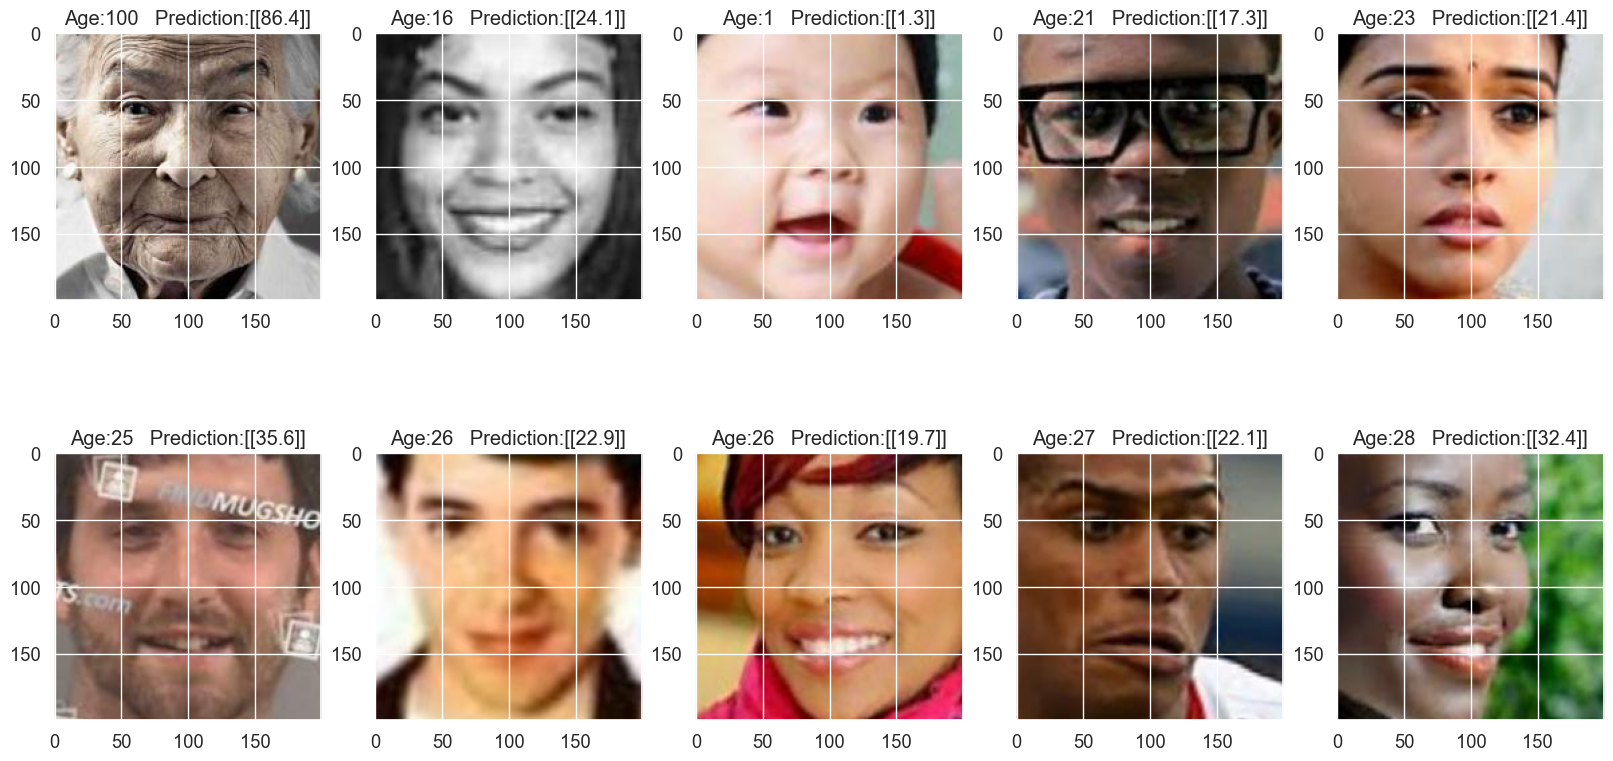

In [52]:
plt.figure(figsize=(20, 10))
c = 1
for i in [200*i for i in range(10)]:
    img = Image.open(os.path.join(DATA_PATH, test_df['filename'].iloc[i]))
    transform = transforms.Compose([transforms.ToTensor()])

    input_tensor = transform(img).unsqueeze(0).cuda()
    pred = model_(input_tensor)
    pred = pred.cpu().detach().numpy()
    plt.subplot(2,5,c); c+=1
    plt.imshow(img) 
    plt.title('Age:' + str(test_df['age'].iloc[i]) + '   Prediction:' + str(np.round(pred, 1))) 